In [1]:
from susy_qm.vqe_metrics import VQESummary
from susy_qm.vqe_plotter import VQEPlotter

import matplotlib.pyplot as plt

In [2]:
cutoffs = [2, 4, 8, 16, 32, 64]
potentials = ["QHO", "AHO", "DW"]

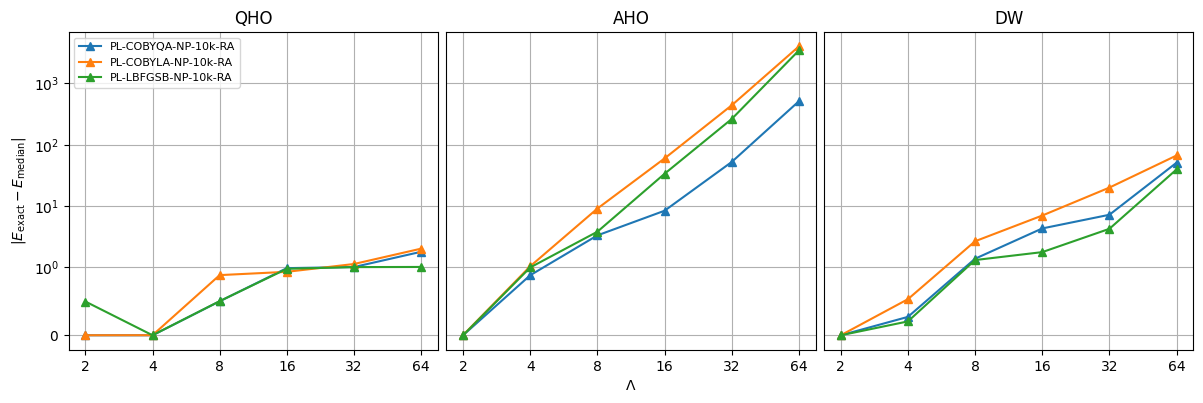

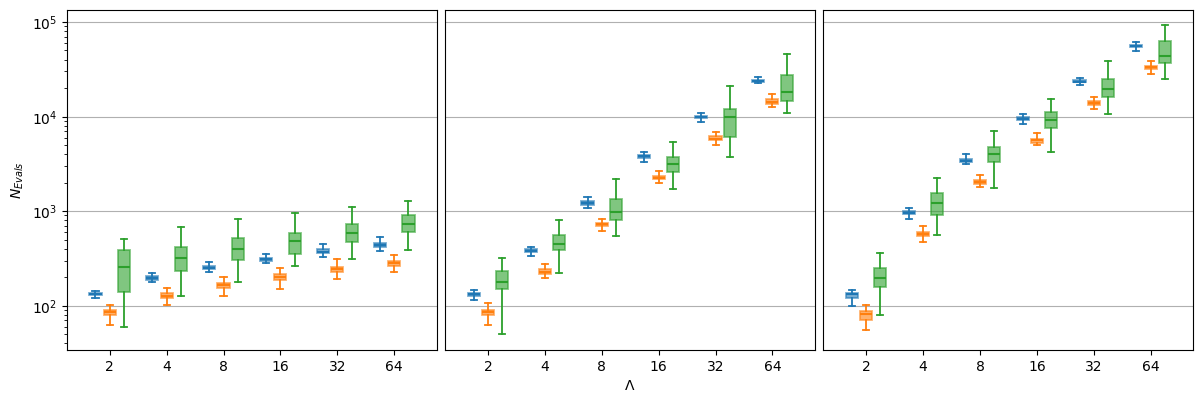

In [3]:
data_paths = [
    ("PL-COBYQA-NP-10k-RA", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesNP-RA\10000"),
    ("PL-COBYLA-NP-10k-RA", r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\Real-Amplitudes\10000"),
    ("PL-LBFGSB-NP-10k-RA", r"SUSY\SUSY QM\PennyLane\L-BFGS-B\PauliDecomp\FilesNP-RA-ParamShift\10000")
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

# ΔE vs cutoff
plotter.plot_delta_e_vs_cutoff_line()
plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=False, show_title=False)
plt.show()

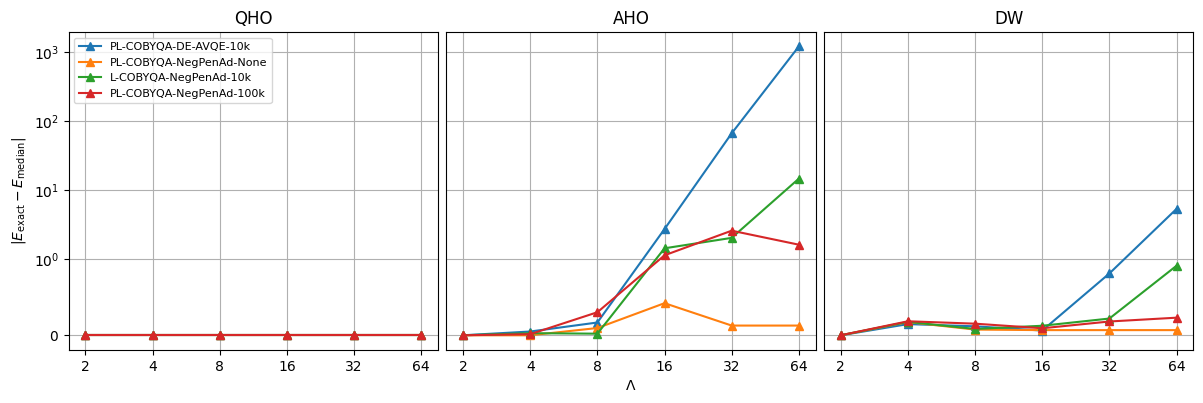

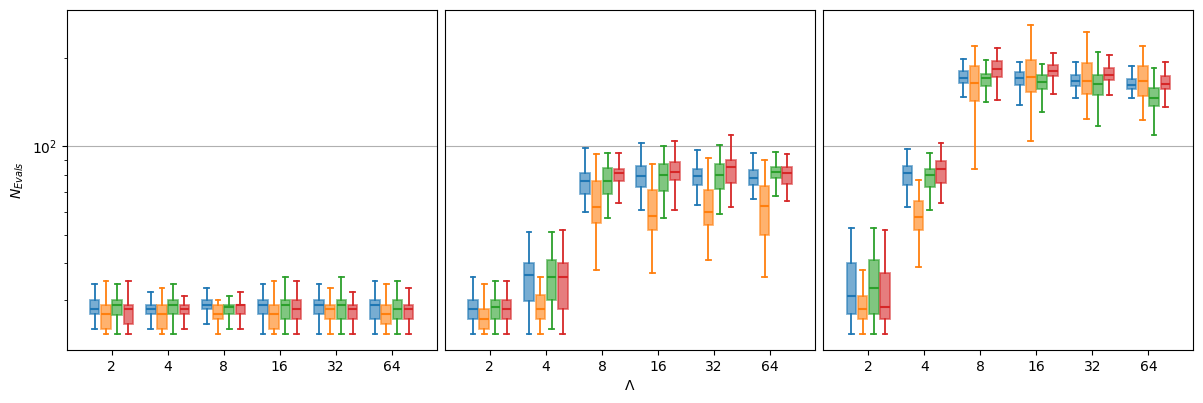

In [4]:
data_paths = [
    ("PL-COBYQA-DE-AVQE-10k", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesDE-AVQE\10000"),
    ("PL-COBYQA-NegPenAd-None", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\NegativePenCostFunc\FilesNegPenAdaptive\None"),
    ("L-COBYQA-NegPenAd-10k", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\NegativePenCostFunc\FilesNegPenAdaptive\10000"),
    ("PL-COBYQA-NegPenAd-100k", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\NegativePenCostFunc\FilesNegPenAdaptive\100000")
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

# ΔE vs cutoff
plotter.plot_delta_e_vs_cutoff_line()
plt.show()

plotter.plot_evals_vs_cutoff_box(box_width=0.2, show_legend=False, show_title=False)
plt.show()
              